In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import collections
import json

GROUP_NO = 43
VOCAB_SIZE = 6000

class WordPieceTokenizer:
    def __init__(self, vocab_size = None):
        self.vocab_size = vocab_size
        self.vocabulary = {"[PAD]", "[UNK]"} # Special tokens

    def get_vocabulary(self):
        '''
        Returns the vocabulary as a sorted list.
        '''
        return sorted(list(self.vocabulary))

    def preprocess_data(self, text):
        """
        Preprocesses the input text data.
        Steps:
        1. Lowercase all text
        2. Remove unwanted characters (punctuation, special symbols)
        3. Split the text into words
        """
        text = text.lower()  # Convert all to lowercase
        text = re.sub(r'[^\w\s]', '' , text)  # Remove punctuation and special symbols
        words = text.split() # Split text into words
        return words


    def get_splits(self, words):
        """
        Computes the frequency of each word and splits each word into characters.
        """
        word_freqs = collections.defaultdict(int)
        for word in words:
            word_freqs[word] += 1

        splits = {
            word: [c if i == 0 else f"##{c}" for i, c in enumerate(word)]
            for word in word_freqs.keys()
        }

        return word_freqs, splits

    def compute_pair_scores(self, word_freqs, splits):
        """
        Computes frequency-based score for token pairs.
        pair_scores = (freq_of_pair)/(freq_of_first_element x freq_of_second_element)
        """
        token_freqs = collections.defaultdict(int)
        pair_freqs = collections.defaultdict(int)

        # Compute frequencies of tokens and token pairs
        for word, freq in word_freqs.items():
            split = splits[word]
            for i in range(len(split) - 1):
                pair = (split[i], split[i + 1])
                token_freqs[split[i]] += freq
                pair_freqs[pair] += freq
            token_freqs[split[-1]] += freq

        # Compute scores for each token pair
        pair_scores = {}
        for pair, freq in pair_freqs.items():
            pair_scores[pair] = freq / (token_freqs[pair[0]] * token_freqs[pair[1]])

        return pair_scores

    def merge_pair(self, a, b, new_token, splits):
        """
        Merges the highest scoring token pair and updates the splits dictionary.
        """
        for word in splits.keys():
            split = splits[word]
            if (len(split) < 2):
                continue
            i = 0
            while (i < len(split) - 1):
                if (split[i] == a and split[i + 1] == b):
                    split = split[:i] + [new_token] + split[i + 2 :]
                else:
                    i += 1
            splits[word] = split
        return splits

    def construct_vocabulary(self, text):
        """
        Builds the vocabulary by merging the highest scoring token pairs iteratively.
        """
        words = self.preprocess_data(text)
        words_freqs, splits = self.get_splits(words)

        for split in splits.values():
            for token in split:
                self.vocabulary.add(token) # Add intial tokens to vocabulary

        while len(self.vocabulary) < self.vocab_size:
            scores = self.compute_pair_scores(words_freqs, splits)

            # Find the best pair to merge
            best_pair, max_score = None, -1
            for pair, score in scores.items():
                if max_score < score:
                    best_pair = pair
                    max_score = score

            if(best_pair is None): # No more pairs to merge
                print("No more pairs to merge.")
                break

            # Merge the best pair
            new_token = (
                best_pair[0] + best_pair[1][2:]
                if best_pair[1].startswith("##")
                else best_pair[0] + best_pair[1]
            )
            splits = self.merge_pair(*best_pair, new_token, splits)

            # Update vocabulary
            self.vocabulary.add(new_token)

    def encode_word(self, word):
        """
        Encodes a word into a list of tokens using the WordPiece algorithm.
        """
        tokens = []
        while len(word) > 0:
            i = len(word)
            while i > 0 and word[:i] not in self.vocabulary:
                i -= 1
            if i == 0:
                return ["[UNK]"]
            tokens.append(word[:i])
            word = word[i:]
            if len(word) > 0:
                word = f"##{word}"
        return tokens

    def tokenize(self, sentence, pad_size=0):
        """
        Tokenizes the input sentence using the WordPiece algorithm.
        """
        pre_processed_sentence = self.preprocess_data(sentence)
        encoded_words = [self.encode_word(word) for word in pre_processed_sentence]
        tokenized_sentence =  sum(encoded_words, [])

        tokenized_sentence = (["[PAD]"] * pad_size) +  tokenized_sentence + (["[PAD]"] * pad_size)

        return tokenized_sentence


if __name__ == "__main__":

    tokenizer = WordPieceTokenizer(vocab_size=VOCAB_SIZE)

    # Read corpus.txt
    with open("/content/drive/MyDrive/NLP_A1/corpus.txt", "r") as file:
        corpus = file.read()

    # Construct vocabulary from corpus
    tokenizer.construct_vocabulary(corpus)

    # Save vocabulary to file
    with open(f"/content/drive/MyDrive/NLP_A1/vocabulary_{GROUP_NO}.txt", "w") as file:
        for token in tokenizer.get_vocabulary():
            file.write(f"{token}\n")
    print(f"Vocabulary saved as 'vocabulary_{GROUP_NO}.txt'.")

    # Read sample_test.json
    with open("/content/drive/MyDrive/NLP_A1/Task 1/sample_test.json", "r") as file:
        sample_test = json.load(file)

    # Tokenize each sentence and store in a dictionary
    tokenized_data = {
        entry["id"]: tokenizer.tokenize(entry["sentence"])
        for entry in sample_test
    }

    # Save tokenized output to a JSON file
    with open(f"/content/drive/MyDrive/NLP_A1/tokenized_{GROUP_NO}.json", "w") as file:
        json.dump(tokenized_data, file, indent=4)

    print(f"Tokenized output saved as 'tokenized_{GROUP_NO}.json'.")


Vocabulary saved as 'vocabulary_43.txt'.
Tokenized output saved as 'tokenized_43.json'.


Epoch 1/20, Train Loss: 5.5454, Val Loss: 4.2349
Epoch 2/20, Train Loss: 3.8969, Val Loss: 3.8215
Epoch 3/20, Train Loss: 3.6046, Val Loss: 3.6513
Epoch 4/20, Train Loss: 3.4434, Val Loss: 3.5548
Epoch 5/20, Train Loss: 3.3275, Val Loss: 3.4923
Epoch 6/20, Train Loss: 3.2367, Val Loss: 3.4425
Epoch 7/20, Train Loss: 3.1590, Val Loss: 3.4103
Epoch 8/20, Train Loss: 3.0961, Val Loss: 3.3814
Epoch 9/20, Train Loss: 3.0414, Val Loss: 3.3639
Epoch 10/20, Train Loss: 2.9908, Val Loss: 3.3529
Epoch 11/20, Train Loss: 2.9462, Val Loss: 3.3384
Epoch 12/20, Train Loss: 2.9054, Val Loss: 3.3320
Epoch 13/20, Train Loss: 2.8695, Val Loss: 3.3271
Epoch 14/20, Train Loss: 2.8382, Val Loss: 3.3245
Epoch 15/20, Train Loss: 2.8072, Val Loss: 3.3237
Epoch 16/20, Train Loss: 2.7783, Val Loss: 3.3229
Epoch 17/20, Train Loss: 2.7518, Val Loss: 3.3235
Epoch 18/20, Train Loss: 2.7281, Val Loss: 3.3251
Epoch 19/20, Train Loss: 2.7088, Val Loss: 3.3293
Epoch 20/20, Train Loss: 2.6874, Val Loss: 3.3293
CBOW Mode

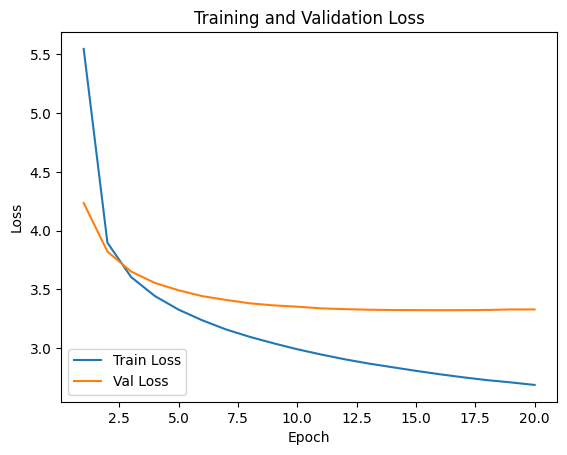

(6000, 150)
Triplets and Cosine Similarities:
Triplet: ('scoffing', 'confus', 'emotionally')
Cosine Similarities: Anchor-Positive: 0.3095, Anchor-Negative: -0.2750, Positive-Negative: -0.0480

Triplet: ('##ctic', 'poking', 'divin')
Cosine Similarities: Anchor-Positive: 0.2727, Anchor-Negative: -0.3095, Positive-Negative: -0.1198



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

WINDOW_SIZE = 2
BATCH_SIZE = 512
EMBEDDING_DIM = 150
EPOCHS = 20
LEARNING_RATE = 0.001
DROPOUT = 0 # Not used in word2vec training

class Word2VecDataset(Dataset):
    def __init__(self, corpus, tokenizer, window_size):
        self.tokenizer = tokenizer
        self.token2idx = {token: i for i, token in enumerate(self.tokenizer.get_vocabulary())} # Create token to index mapping
        self.idx2token = {i: token for token, i in self.token2idx.items()} # Create index to token mapping
        self.window_size = window_size # Total (2*window_size) context words
        self.data = self.preprocess_data(corpus)

    def preprocess_data(self, corpus):
        """Prepares CBOW training data using WordPieceTokenizer."""
        corpus = corpus.split('\n')  # Split corpus into sentences
        data = []  # List to store training data
        for sentence in corpus:
            tokenized_sentence = self.tokenizer.tokenize(sentence, pad_size = self.window_size)  # Tokenize using WordPiece
            tokenized_sentence = [self.token2idx.get(token, -1) for token in tokenized_sentence]  # Map tokens to indices (integer values)

            # Generate CBOW training pairs
            for i in range(len(tokenized_sentence) - (2 * self.window_size) ):
                context = tokenized_sentence[i:i + self.window_size] + tokenized_sentence[i + self.window_size + 1:i + (2*self.window_size+1)]
                target = tokenized_sentence[i + self.window_size]
                data.append((context, target))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context, target = self.data[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)


class Word2VecModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dropout=DROPOUT):
        super(Word2VecModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim) # Embedding layer to convert indices to embeddings
        # self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(embedding_dim, vocab_size) # Fully connected layer to predict target word

    def forward(self, context):
        """Forward pass for CBOW."""
        embedded = self.embeddings(context).mean(dim=1)  # Averaging embeddings
        # embedded = self.dropout(embedded)
        out = self.linear(embedded)
        return out

def train(model, train_loader, val_loader, epochs, lr):

    # Initialize loss function and optimizer
    criterion = nn.CrossEntropyLoss() # CrossEntropyLoss is used because the model predicts a probability distribution over the vocabulary.
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train() # Set moSets the model to training mode (dropout/batch normalization if used).
        train_loss = 0.0 # Training loss for the epoch
        for context, target in train_loader: # Iterate over the training dataset batch by batch
            context, target = context.to(model.embeddings.weight.device), target.to(model.embeddings.weight.device) # Move data to the device (GPU/CPU)
            optimizer.zero_grad() # Clears the gradients from the previous iteration.
            output = model(context) # Forward pass
            loss = criterion(output, target) # Compute loss
            loss.backward() # Backpropagates the loss to compute gradients.
            optimizer.step() # Updates the model parameters using the computed gradients.
            train_loss += loss.item() # Accumulate loss for the epoch
        train_losses.append(train_loss / len(train_loader)) # Average training loss for the epoch

        model.eval() # Sets the model to evaluation mode (disables dropout/batch normalization if used).
        val_loss = 0.0
        with torch.no_grad(): # Disables gradient computation for validation
            for context, target in val_loader: # Iterate over the validation dataset batch by batch
                context, target = context.to(model.embeddings.weight.device), target.to(model.embeddings.weight.device) # Move data to the device (GPU/CPU)
                output = model(context) # Forward pass
                loss = criterion(output, target) # Compute loss
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader)) # Average validation loss for the epoch

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend(loc="lower left")
    plt.savefig("/content/drive/MyDrive/NLP_A1/cbow_losses.png")
    plt.show()

def cosine_similarity(vec1, vec2):
    """
    Compute cosine similarity between two vectors.
    """
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def find_triplets(dataset, model, no_of_triplets=2):
    """
    Returns a list of triplets: (anchor, positive, negative),
    where anchor and positive have high cosine similarity,
    and negative has low similarity with the anchor.
    Also returns cosine similarity scores across all pairs in each triplet.
    """
    triplets = []
    cosine_similarities = []  # To store cosine similarities for each triplet
    embeddings = model.embeddings.weight.data.cpu().numpy()  # Get embedding matrix
    tokens_idx = list(dataset.idx2token.keys())  # List of token indices
    token_list = list(dataset.idx2token.values())  # List of actual tokens

    # Compute cosine similarity matrix
    similarity_matrix = np.dot(embeddings, embeddings.T)  # Dot product of embeddings
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    similarity_matrix /= np.dot(norms, norms.T)  # Normalize to get cosine similarity

    # Generate triplets
    np.random.shuffle(tokens_idx)  # Shuffle to avoid bias
    for anchor_idx in tokens_idx[:no_of_triplets]:  # Pick triplet count
        similarities = similarity_matrix[anchor_idx]  # Similarity scores for the anchor

        # Find the most similar (positive) and least similar (negative) words
        sorted_indices = np.argsort(-similarities)  # Sort in descending order (highest first)
        positive_idx = sorted_indices[1]  # First most similar (excluding itself)
        negative_idx = sorted_indices[-1]  # Least similar word

        anchor, positive, negative = token_list[anchor_idx], token_list[positive_idx], token_list[negative_idx]

        # Cosine similarities for each pair
        anchor_positive_similarity = similarities[positive_idx]
        anchor_negative_similarity = similarities[negative_idx]
        positive_negative_similarity = similarity_matrix[positive_idx, negative_idx]

        triplets.append((anchor, positive, negative))
        cosine_similarities.append((anchor_positive_similarity, anchor_negative_similarity, positive_negative_similarity))

    return triplets, cosine_similarities


if __name__ == "__main__":

    # Load corpus
    with open("/content/drive/MyDrive/NLP_A1/corpus.txt", "r") as file:
        corpus = file.read()

    # Initialize tokenizer from Task 1
    tokenizer = WordPieceTokenizer()

    # Load vocabulary
    # Method 1: Load vocabulary from file
    with open(f"/content/drive/MyDrive/NLP_A1/vocabulary_{GROUP_NO}.txt", "r") as file:
        for line in file:
            tokenizer.vocabulary.add(line.strip())
    # Method 2: Construct vocabulary from corpus
    # tokenizer.construct_vocabulary(corpus)

    # Create dataset
    dataset = Word2VecDataset(corpus, tokenizer, window_size=WINDOW_SIZE)
    # Split dataset into training and validation sets (90:10 split)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize Word2Vec CBOW model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    cbow_model = Word2VecModel(vocab_size=len(tokenizer.get_vocabulary()), embedding_dim=EMBEDDING_DIM).to(device)

    # Train model
    train_losses, val_losses = train(cbow_model, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE)
    # Save model
    torch.save(cbow_model.state_dict(), "/content/drive/MyDrive/NLP_A1/word2vec_cbow.pth")
    print("CBOW Model trained and checkpoint saved as 'word2vec_cbow.pth'.")
    # Plot losses
    plot_losses(train_losses, val_losses)
    # get triplets
    triplets,cosine_similarities = find_triplets(dataset, cbow_model, no_of_triplets=2)
    print("Triplets and Cosine Similarities:")
    for triplet, similarities in zip(triplets, cosine_similarities):
        print(f"Triplet: {triplet}")
        print(f"Cosine Similarities: Anchor-Positive: {similarities[0]:.4f}, Anchor-Negative: {similarities[1]:.4f}, Positive-Negative: {similarities[2]:.4f}")
        print()



Training LM1...
Epoch 1/10, Train Loss: 3.9004, Val Loss: 3.1701
Epoch 2/10, Train Loss: 2.9644, Val Loss: 2.9838
Epoch 3/10, Train Loss: 2.7269, Val Loss: 2.9098
Epoch 4/10, Train Loss: 2.5638, Val Loss: 2.8724
Epoch 5/10, Train Loss: 2.4357, Val Loss: 2.8698
Epoch 6/10, Train Loss: 2.3294, Val Loss: 2.8752
Epoch 7/10, Train Loss: 2.2412, Val Loss: 2.8983
Epoch 8/10, Train Loss: 2.1650, Val Loss: 2.9197
Epoch 9/10, Train Loss: 2.0998, Val Loss: 2.9381
Epoch 10/10, Train Loss: 2.0453, Val Loss: 2.9654
LM1 - Train Accuracy: 54.11%, Validation Accuracy: 46.64%
LM1 - Train Perplexity: 6.97, Validation Perplexity: 20.32

Training LM2...
Epoch 1/10, Train Loss: 3.7974, Val Loss: 3.1420
Epoch 2/10, Train Loss: 2.9214, Val Loss: 2.9260
Epoch 3/10, Train Loss: 2.6782, Val Loss: 2.8590
Epoch 4/10, Train Loss: 2.5124, Val Loss: 2.8121
Epoch 5/10, Train Loss: 2.3804, Val Loss: 2.7970
Epoch 6/10, Train Loss: 2.2640, Val Loss: 2.8315
Epoch 7/10, Train Loss: 2.1604, Val Loss: 2.8547
Epoch 8/10, Tra

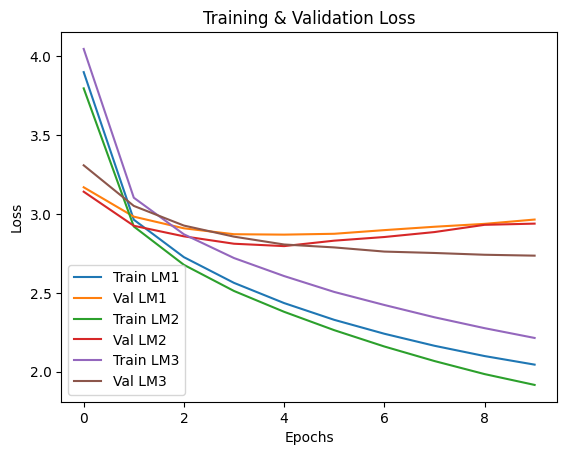

In [ ]:
import os
CONTEXT_SIZE_LM = 4
BATCH_SIZE_LM = 512
LEARNING_RATE_LM = 0.0005
EPOCHS_LM = 10

class NeuralLMDataset(Dataset):
    def __init__(self, corpus, tokenizer, word2vec_model, context_size):
        """
        Custom dataset for training a Neural Language Model.

        Args:
            corpus (str): The text corpus.
            tokenizer (WordPieceTokenizer): The tokenizer from Task 1.
            word2vec_model (Word2VecModel): Pre-trained Word2Vec model from Task 2.
            context_size (int): Number of previous words to use as input.
        """
        self.tokenizer = tokenizer
        self.token2idx = {token: i for i, token in enumerate(self.tokenizer.get_vocabulary())} # Create token to index mapping
        self.word2vec_model = word2vec_model
        self.context_size = context_size
        # Tokenize corpus and map tokens to embeddings
        self.data = self.preprocess_data(corpus)

    def preprocess_data(self, corpus):
        """Tokenizes the corpus and prepares training data."""
        corpus = corpus.split("\n")  # Split into sentences
        data = []

        for sentence in corpus:
            tokenized_sentence = self.tokenizer.tokenize(sentence, pad_size = self.context_size)  # Tokenize using WordPiece
            tokenized_sentence = [self.token2idx.get(token, -1) for token in tokenized_sentence]  # Map tokens to indices (integer values)

            # Generate context-target pairs
            for i in range(len(tokenized_sentence) - (2 * self.context_size)):
                context = tokenized_sentence[i:i + self.context_size]  # Previous N words
                target = tokenized_sentence[i + self.context_size]  # Next word
                data.append((torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Returns concatenated word embeddings as input and target word index."""
        context, target = self.data[idx]

        # Convert context tokens to embeddings (get embeddings from Word2Vec model)
        with torch.no_grad():  # Disable gradient tracking
            context,target = context.to(self.word2vec_model.embeddings.weight.device), target.to(self.word2vec_model.embeddings.weight.device)
            context_embeddings = self.word2vec_model.embeddings(context)

        # Flatten the concatenated embeddings (size: embedding_dim * context_size)
        context_vector = context_embeddings.view(-1)

        return context_vector, target



class NeuralLM1(nn.Module):
    """Single hidden layer [256] with ReLU activation."""
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NeuralLM1, self).__init__()
        input_dim = embedding_dim * context_size  # Compute input size
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu = nn.ReLU()
        self.output = nn.Linear(256, vocab_size)  # Predict next word index

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.output(x)  # No softmax (CrossEntropyLoss applies it internally)
        return x


class NeuralLM2(nn.Module):
    """Two hidden layers [256, 512] with ReLU activation."""
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NeuralLM2, self).__init__()
        input_dim = embedding_dim * context_size
        self.fc1 = nn.Linear(input_dim, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 512)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(512, vocab_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.output(x)
        return x


class NeuralLM3(nn.Module):
    """Single hidden layer [256] with Tanh activation."""
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NeuralLM3, self).__init__()
        input_dim = embedding_dim * context_size
        self.fc1 = nn.Linear(input_dim, 256)
        self.tanh = nn.Tanh()
        self.output = nn.Linear(256, vocab_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.output(x)
        return x

def train(model, train_loader, val_loader, epochs, lr):

    # Initialize loss function and optimizer
    criterion = nn.CrossEntropyLoss() # CrossEntropyLoss is used because the model predicts a probability distribution over the vocabulary.
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train() # Set moSets the model to training mode (dropout/batch normalization if used).
        train_loss = 0.0 # Training loss for the epoch
        for context, target in train_loader: # Iterate over the training dataset batch by batch
            context, target = context.to(next(model.parameters()).device), target.to(next(model.parameters()).device) # Move data to the device (GPU/CPU)
            optimizer.zero_grad() # Clears the gradients from the previous iteration.
            output = model(context) # Forward pass
            loss = criterion(output, target) # Compute loss
            loss.backward() # Backpropagates the loss to compute gradients.
            optimizer.step() # Updates the model parameters using the computed gradients.
            train_loss += loss.item() # Accumulate loss for the epoch
        train_losses.append(train_loss / len(train_loader)) # Average training loss for the epoch

        model.eval() # Sets the model to evaluation mode (disables dropout/batch normalization if used).
        val_loss = 0.0
        with torch.no_grad(): # Disables gradient computation for validation
            for context, target in val_loader: # Iterate over the validation dataset batch by batch
                context, target = context.to(next(model.parameters()).device), target.to(next(model.parameters()).device) # Move data to the device (GPU/CPU)
                output = model(context) # Forward pass
                loss = criterion(output, target) # Compute loss
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader)) # Average validation loss for the epoch

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


def compute_accuracy(model, dataloader, device):
    """Computes accuracy of the model on a given dataset."""
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass

            # Get predicted token (highest probability)
            predicted = torch.argmax(outputs, dim=1)

            # Compare with actual target tokens
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    accuracy = correct / total * 100  # Convert to percentage
    return accuracy


def compute_perplexity(model, dataloader, device):
    """Computes perplexity score for the model on a given dataset."""
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    total_words = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass

            # Compute loss using cross-entropy
            loss = torch.nn.functional.cross_entropy(outputs, targets, reduction="sum")
            total_loss += loss.item()
            total_words += targets.size(0)

    # Compute perplexity = exp(average loss)
    perplexity = torch.exp(torch.tensor(total_loss / total_words)).item()
    return perplexity


def predict_next_tokens(model, sentence, tokenizer, word2vec_model, context_size, num_predictions=3):
    """
    Predicts the next 'num_predictions' tokens one by one for a given sentence.

    Args:
        model: Trained neural language model.
        sentence (str): Input sentence.
        tokenizer (WordPieceTokenizer): Tokenizer.
        word2vec_model (Word2VecModel): Pre-trained Word2Vec model.
        context_size (int): Context window size.
        num_predictions (int): Number of Next tokens to predict.

    Returns:
        List of predicted tokens.
    """
    model.eval()  # Set model to evaluation mode
    predicted_tokens = []

    # Tokenize input sentence
    tokenized_sentence = tokenizer.tokenize(sentence, pad_size=context_size)

    # Convert tokens to indices
    token_to_idx = {token: i for i, token in enumerate(tokenizer.get_vocabulary())}
    idx_to_token = {i: token for token, i in token_to_idx.items()}
    context = [token_to_idx.get(token, -1) for token in tokenized_sentence]  # Map tokens to indices
    context = context[-2*context_size:-context_size]  # Limit context to context_size

    for _ in range(num_predictions):
        # Convert context tokens to embeddings
        with torch.no_grad():
            context_tensor = torch.tensor(context, dtype=torch.long).to(next(model.parameters()).device)
            context_embeddings = word2vec_model.embeddings(context_tensor).view(-1)  # Flatten

        # Predict next token
        output = model(context_embeddings.unsqueeze(0))  # Add batch dimension
        predicted_idx = torch.argmax(output, dim=1).item()  # Get highest probability token

        # Get the corresponding token
        predicted_token = idx_to_token.get(predicted_idx, "[UNK]")  # Default to [UNK] if token not found
        predicted_tokens.append(predicted_token)

        # Update context by adding the predicted token and removing the first one
        context.append(predicted_idx)
        context.pop(0)  # Maintain context size

    return predicted_tokens

def predict_txt(model, file_path, num_predictions, tokenizer, word2vec_model, context_size, model_name="LM_Model"):
    """
    Predicts the next 'num_predictions' tokens for each line in a text file and saves the results.

    Args:
        model: Trained neural language model.
        file_path (str): Path to the text file.
        num_predictions (int): Number of next tokens to predict.
        tokenizer: Tokenizer used for tokenizing input text.
        word2vec_model: Pre-trained Word2Vec model.
        context_size (int): Context window size.
        model_name (str): Name of the model for output file naming.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file '{file_path}' does not exist.")
    
    output_file = f"{model_name}_predictions.txt"
    
    with open(file_path, "r", encoding="utf-8") as file, open(output_file, "w", encoding="utf-8") as output:
        lines = file.readlines()
        for line in lines:
            cleaned_line = line.strip()
            if not cleaned_line:
                continue  # Skip empty lines
            
            predicted_tokens = predict_next_tokens(model, cleaned_line, tokenizer, word2vec_model, context_size, num_predictions)
            predicted_text = " ".join(predicted_tokens)
            output.write(f"Input: {cleaned_line}\nPredicted: {predicted_text}\n\n")
    
    print(f"Predictions saved to {output_file}")



if __name__ == "__main__":

    # Load corpus
    with open("/content/drive/MyDrive/NLP_A1/corpus.txt", "r") as file:
        corpus = file.read()

    # Initialize tokenizer from Task 1
    tokenizer = WordPieceTokenizer()

    # Load vocabulary
    # Method 1: Load vocabulary from file
    with open(f"/content/drive/MyDrive/NLP_A1/vocabulary_{GROUP_NO}.txt", "r") as file:
        for line in file:
            tokenizer.vocabulary.add(line.strip())
    # Method 2: Construct vocabulary from corpus
    # tokenizer.construct_vocabulary(corpus)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load pre-trained Word2Vec  model
    trained_cbow_checkpoint = torch.load("/content/drive/MyDrive/NLP_A1/word2vec_cbow.pth", map_location=device, weights_only=True)
    saved_vocab_size, saved_embedding_dim = trained_cbow_checkpoint["embeddings.weight"].shape
    word2vec_model = Word2VecModel(vocab_size=saved_vocab_size, embedding_dim=saved_embedding_dim)
    word2vec_model.load_state_dict(trained_cbow_checkpoint)
    word2vec_model.to(device)
    word2vec_model.eval() # Set model to evaluation mode

    # Create dataset
    dataset = NeuralLMDataset(corpus, tokenizer, word2vec_model, context_size=CONTEXT_SIZE_LM)

    # Split dataset into training and validation sets (90:10 split)
    train_size = int(0.9 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_LM, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_LM, shuffle=False)

    for model_class, name in zip([NeuralLM1, NeuralLM2, NeuralLM3], ["LM1", "LM2", "LM3"]):
        print(f"\nTraining {name}...")
        model = model_class(saved_vocab_size, saved_embedding_dim, context_size=CONTEXT_SIZE_LM).to(device)
        train_losses, val_losses = train(model, train_loader, val_loader, epochs=EPOCHS_LM, lr=LEARNING_RATE_LM)

        # Compute accuracy and perplexity
        train_accuracy = compute_accuracy(model, train_loader, device)
        val_accuracy = compute_accuracy(model, val_loader, device)
        train_perplexity = compute_perplexity(model, train_loader, device)
        val_perplexity = compute_perplexity(model, val_loader, device)

        print(f"{name} - Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")
        print(f"{name} - Train Perplexity: {train_perplexity:.2f}, Validation Perplexity: {val_perplexity:.2f}")

        # Plot losses
        plt.plot(train_losses, label=f"Train {name}")
        plt.plot(val_losses, label=f"Val {name}")

        # Predict Sample test
        predict_txt(model, "/content/drive/MyDrive/NLP_A1/Task 3/sample_test.txt", 3, tokenizer, word2vec_model, CONTEXT_SIZE_LM, name)

        # Save model
        torch.save(model.state_dict(), f"/content/drive/MyDrive/NLP_A1/neural_{name}.pth")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.title("Training & Validation Loss")
    plt.savefig("/content/drive/MyDrive/NLP_A1/Neural_LM_losses")
    plt.show()